In [1]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/72.0 MB 3.1 MB/s eta 0:00:23
   -- ------------------------------------- 4.2/72.0 MB 9.6 MB/s eta 0:00:08
   -------- ------------------------------- 15.2/72.0 MB 25.7 MB/s eta 0:00:03
   --------- ------------------------------ 16.8/72.0 MB 21.4 MB/s eta 0:00:03
   ---------- ----------------------------- 19.4/72.0 MB 18.8 MB/s eta 0:00:03
   ------------ --------------------------- 22.0/72.0 MB 18.3 MB/s eta 0:00:03
   -------------- ------------------------- 26.0/72.0 MB 17.9 MB/s eta 0:00:03
   ----------------- ---------------------- 31.7/72.0 MB 19.1 MB/s eta 0:00:03
   ------------------- -------------------- 34.6/72.0 MB 18.9 MB/s eta 0:00:02
   --------------------- ------------------ 39.1/72.0 MB 18.7 MB/s eta 0:00:02
   ----------------------- ---------------- 41.7/72.0 MB 18.5 MB/s eta 0:0


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss

# 1. Import Data

In [4]:
# 載入乳癌資料集
breast_cancer = load_breast_cancer()

In [5]:
print("特徵數量：", breast_cancer.data.shape[1])
print("樣本數量：", breast_cancer.data.shape[0])
print("類別種類：", breast_cancer.target_names)
print("目標分佈：", pd.Series(data.target).value_counts())

特徵數量： 30
樣本數量： 569
類別種類： ['malignant' 'benign']


NameError: name 'data' is not defined

In [32]:
# 轉換為 DataFrame
df = pd.DataFrame(data=breast_cancer.data, columns=breast_cancer.feature_names)

# 如果你也想把標籤（target）加入進來，可以這樣：
df['target'] = breast_cancer.target

# 顯示前幾筆資料確認
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### 十個基本特徵（對應腫瘤影像的性狀）
| 特徵名稱               | 說明                                | 意義                              |
|:-----------------------|:----------------------------------|:----------------------------------|
| **radius**             | 腫瘤半徑                           | 反映腫瘤大小，較大的半徑可能與惡性腫瘤相關。 |
| **texture**            | 紋理（灰度變化)                     | 描述腫瘤表面的規則性或不規則性，紋理不均勻通常與惡性腫瘤相關。 |
| **perimeter**          | 腫瘤周長                           | 反映腫瘤邊緣的長度，周長較大的腫瘤通常較大，可能是惡性的。 |
| **area**               | 面積平均                            | 描述腫瘤的面積，較大的面積可能與惡性腫瘤相關。 |
| **smoothness**         | 邊界平滑程度                        | 描述腫瘤邊界的規則性，較平滑的邊界通常是良性腫瘤的特徵。 |
| **compactness**        | 緊密度 = 周長² / 面積 - 1            | 緊密度高通常與良性腫瘤相關，低緊密度則可能與惡性腫瘤相關。 |
| **concavity**          | 凹度（輪廓的內凹程度）               | 较高的凹度通常表示不規則邊界，這是惡性腫瘤的特徵。 |
| **concave points**     | 凹點數量                           | 较多的凹點數量顯示腫瘤邊界不規則，這通常與惡性腫瘤相關。 |
| **symmetry**           | 對稱性                             | 對稱性良好的腫瘤通常是良性的，惡性腫瘤形狀往往不對稱。數值越大，表示腫瘤的對稱性越好。 |
| **fractal dimension**  | 分形維度（邊界複雜度）               | 較高的分形維度表示腫瘤邊界複雜，這通常與惡性腫瘤相關。 |



### 特徵類型說明
30 個特徵來自 10 個基本特徵，每個基本特徵都有以下三種統計量：

* mean：平均值，提供整體的概覽，反映樣本中大部分腫瘤的典型特徵。    
  意義：平均值可以幫助描述樣本中大多數腫瘤的一般情況，它是了解腫瘤普遍特徵的重要指標。對於某些特徵，較高或較低的平均值可能顯示出腫瘤的潛在風險。
  
* se（standard error）：標準誤差，衡量特徵在樣本中的變異性，幫助評估該特徵的穩定性。較大的標準誤差意味著該特徵在不同腫瘤樣本中的變化較大。    
  意義：標準誤差可以幫助衡量該特徵的穩定性或一致性。當某個特徵的標準誤差較小時，表示這個特徵在所有樣本中更為穩定，反之，標準誤差較大的特徵可能顯示出較大差異，這對於判斷某些腫瘤特徵的可靠性至關重要。對於模型預測，它幫助了解是否可以對某個特徵進行有效的預測。

* worst：最大值或最惡劣情況的值（在該筆樣本的 10 個最大細胞中），揭示腫瘤的最極端情況，通常有助於識別惡性腫瘤的特徵。    
  意義：最惡劣情況值能反映出腫瘤在極端情況下的特徵，這對於識別最具侵襲性的腫瘤（即惡性腫瘤）至關重要。惡性腫瘤通常會表現出最大的周長、最差的對稱性、最不平滑的邊界等，因此 worst 統計量是預測腫瘤是否惡性的重要指標。    

#### 綜合分析：結合所有三個統計量
意義： 通過結合 mean、se 和 worst 進行多維度的觀察，可以更全面地了解腫瘤的特徵。
* (1)惡性腫瘤：通常會顯示出mean與worst之間的顯著差距，se較高。這表明腫瘤在正常情況下表現較為穩定，但在極端情況下，特徵可能會劇烈變化，反映出其惡性。
* (2)良性腫瘤：mean和worst之間的差異較小，且se較低，表明這些腫瘤的特徵在樣本間較為一致且較為規則。

### 標籤說明（target）
0 = 惡性（malignant）    
1 = 良性（benign）

# 2. 敘述性統計

### 2.1 特徵分佈的直方圖

<Figure size 1500x1000 with 0 Axes>

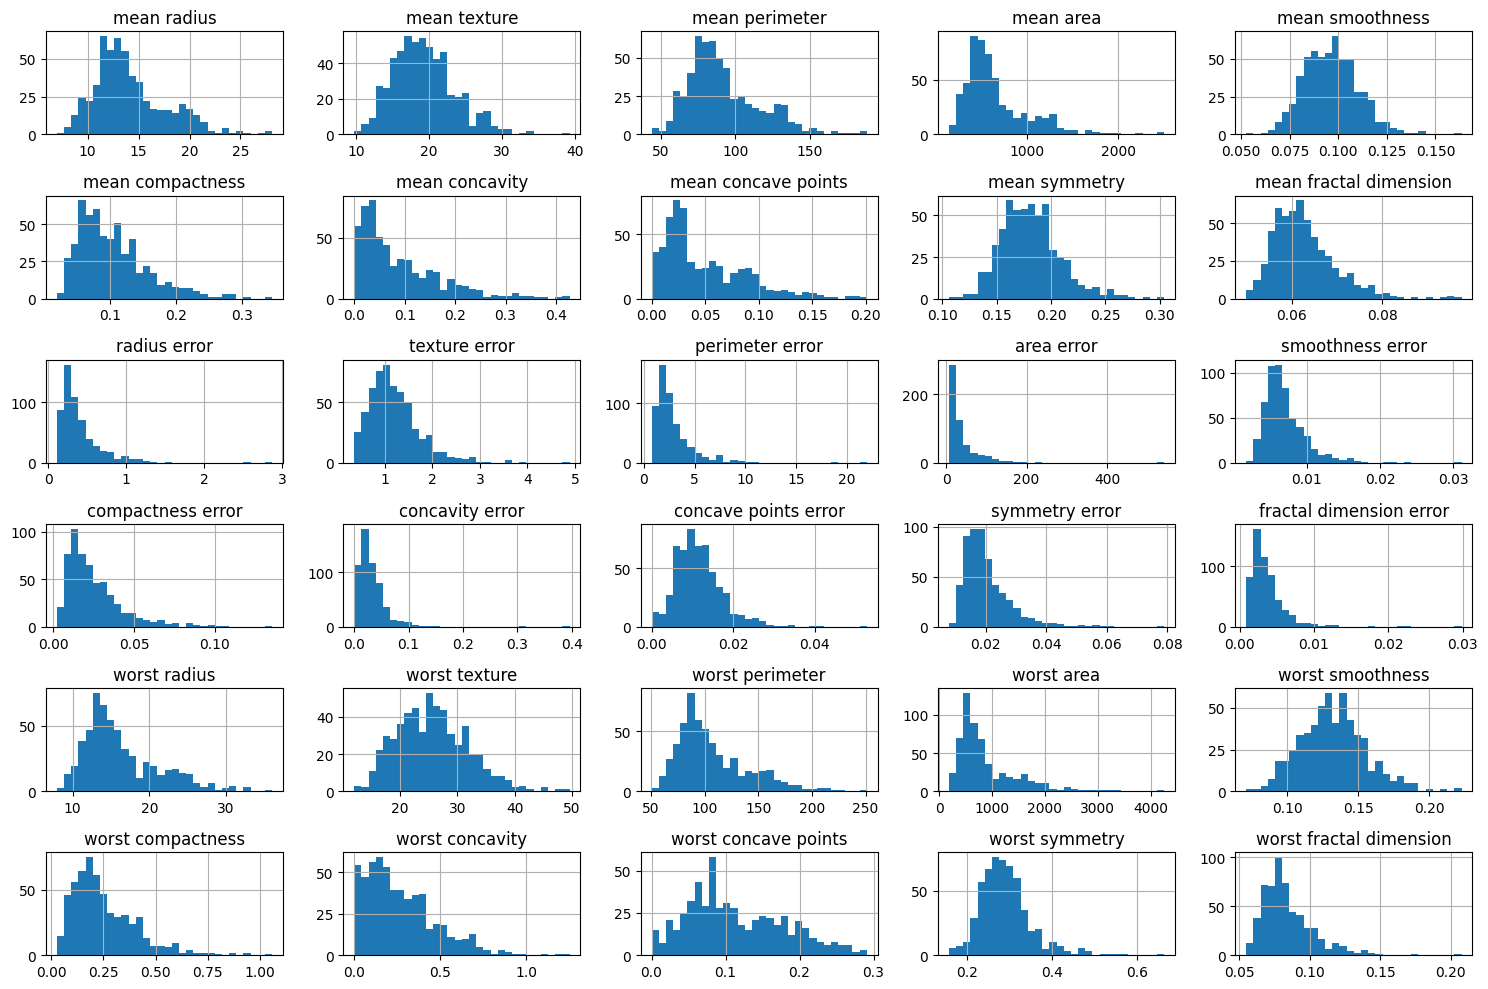

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置畫布大小
plt.figure(figsize=(15, 10))

# 繪製每個特徵的直方圖
df.drop('target', axis=1).hist(bins=30, figsize=(15, 10), layout=(6, 5))
plt.tight_layout()
plt.show()

### 2.2 各特徵間的相關性熱圖

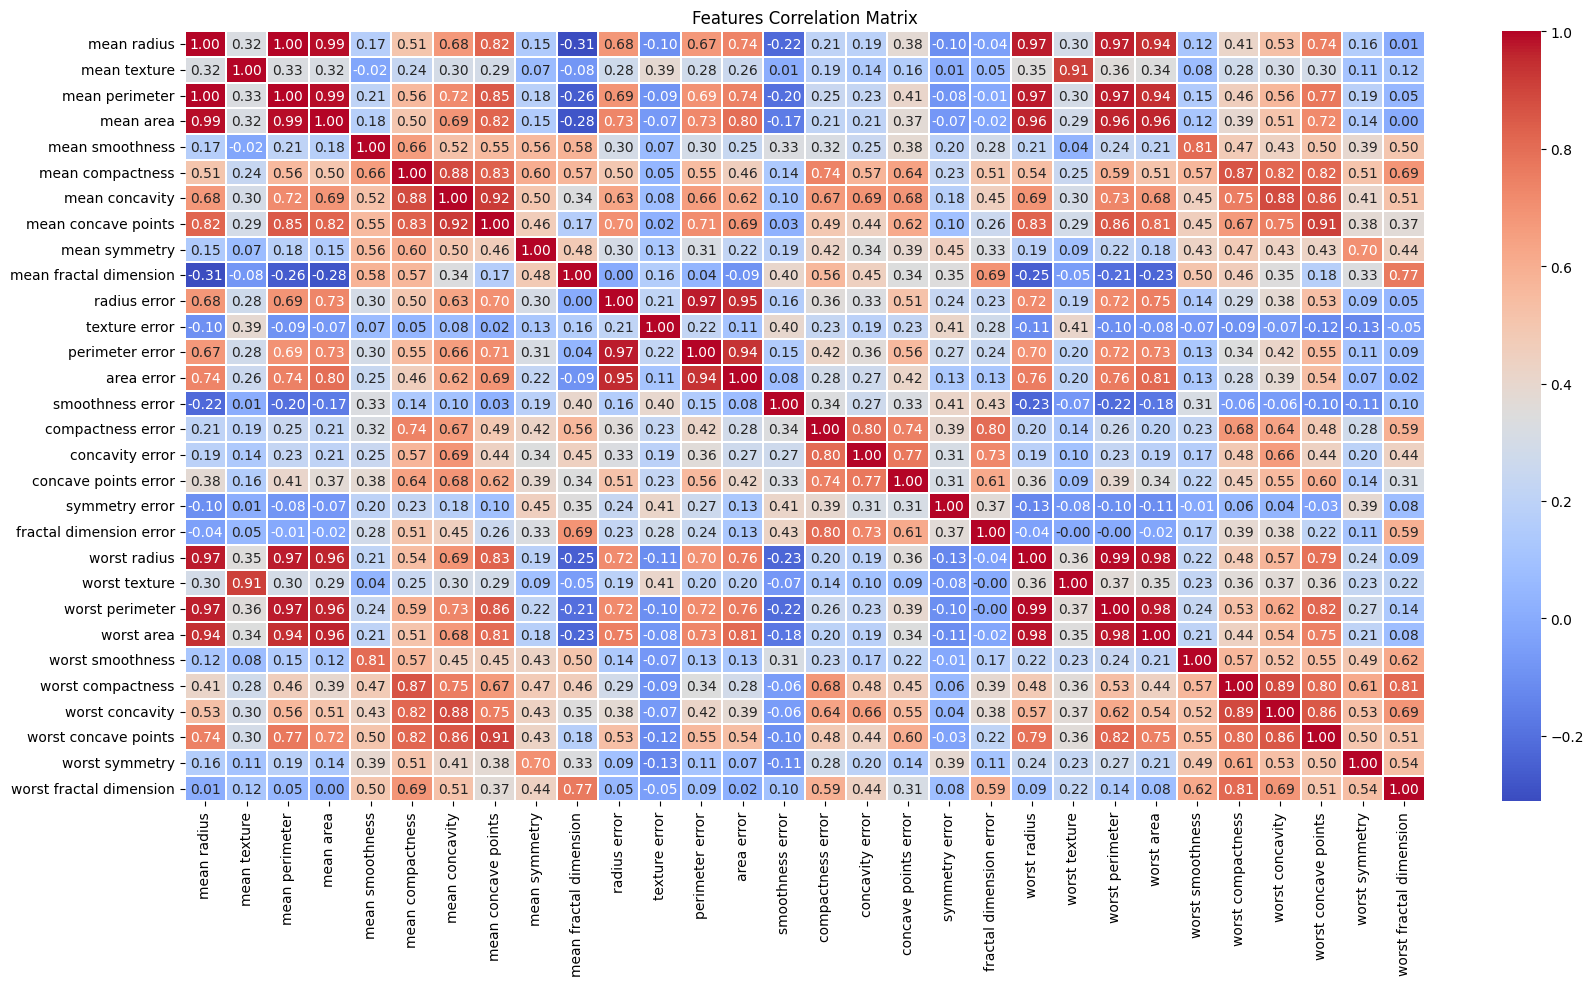

In [46]:
# 計算相關性矩陣
correlation_matrix = df.drop('target', axis=1).corr()

# 繪製相關性熱圖
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.3)
plt.title("Features Correlation Matrix")
plt.show()

### 2.3 不同類別的分佈（根據腫瘤類型）
根據 target（腫瘤類型：良性或惡性）來觀察特徵的分佈，看看不同類型的腫瘤在這些特徵上有什麼區別。

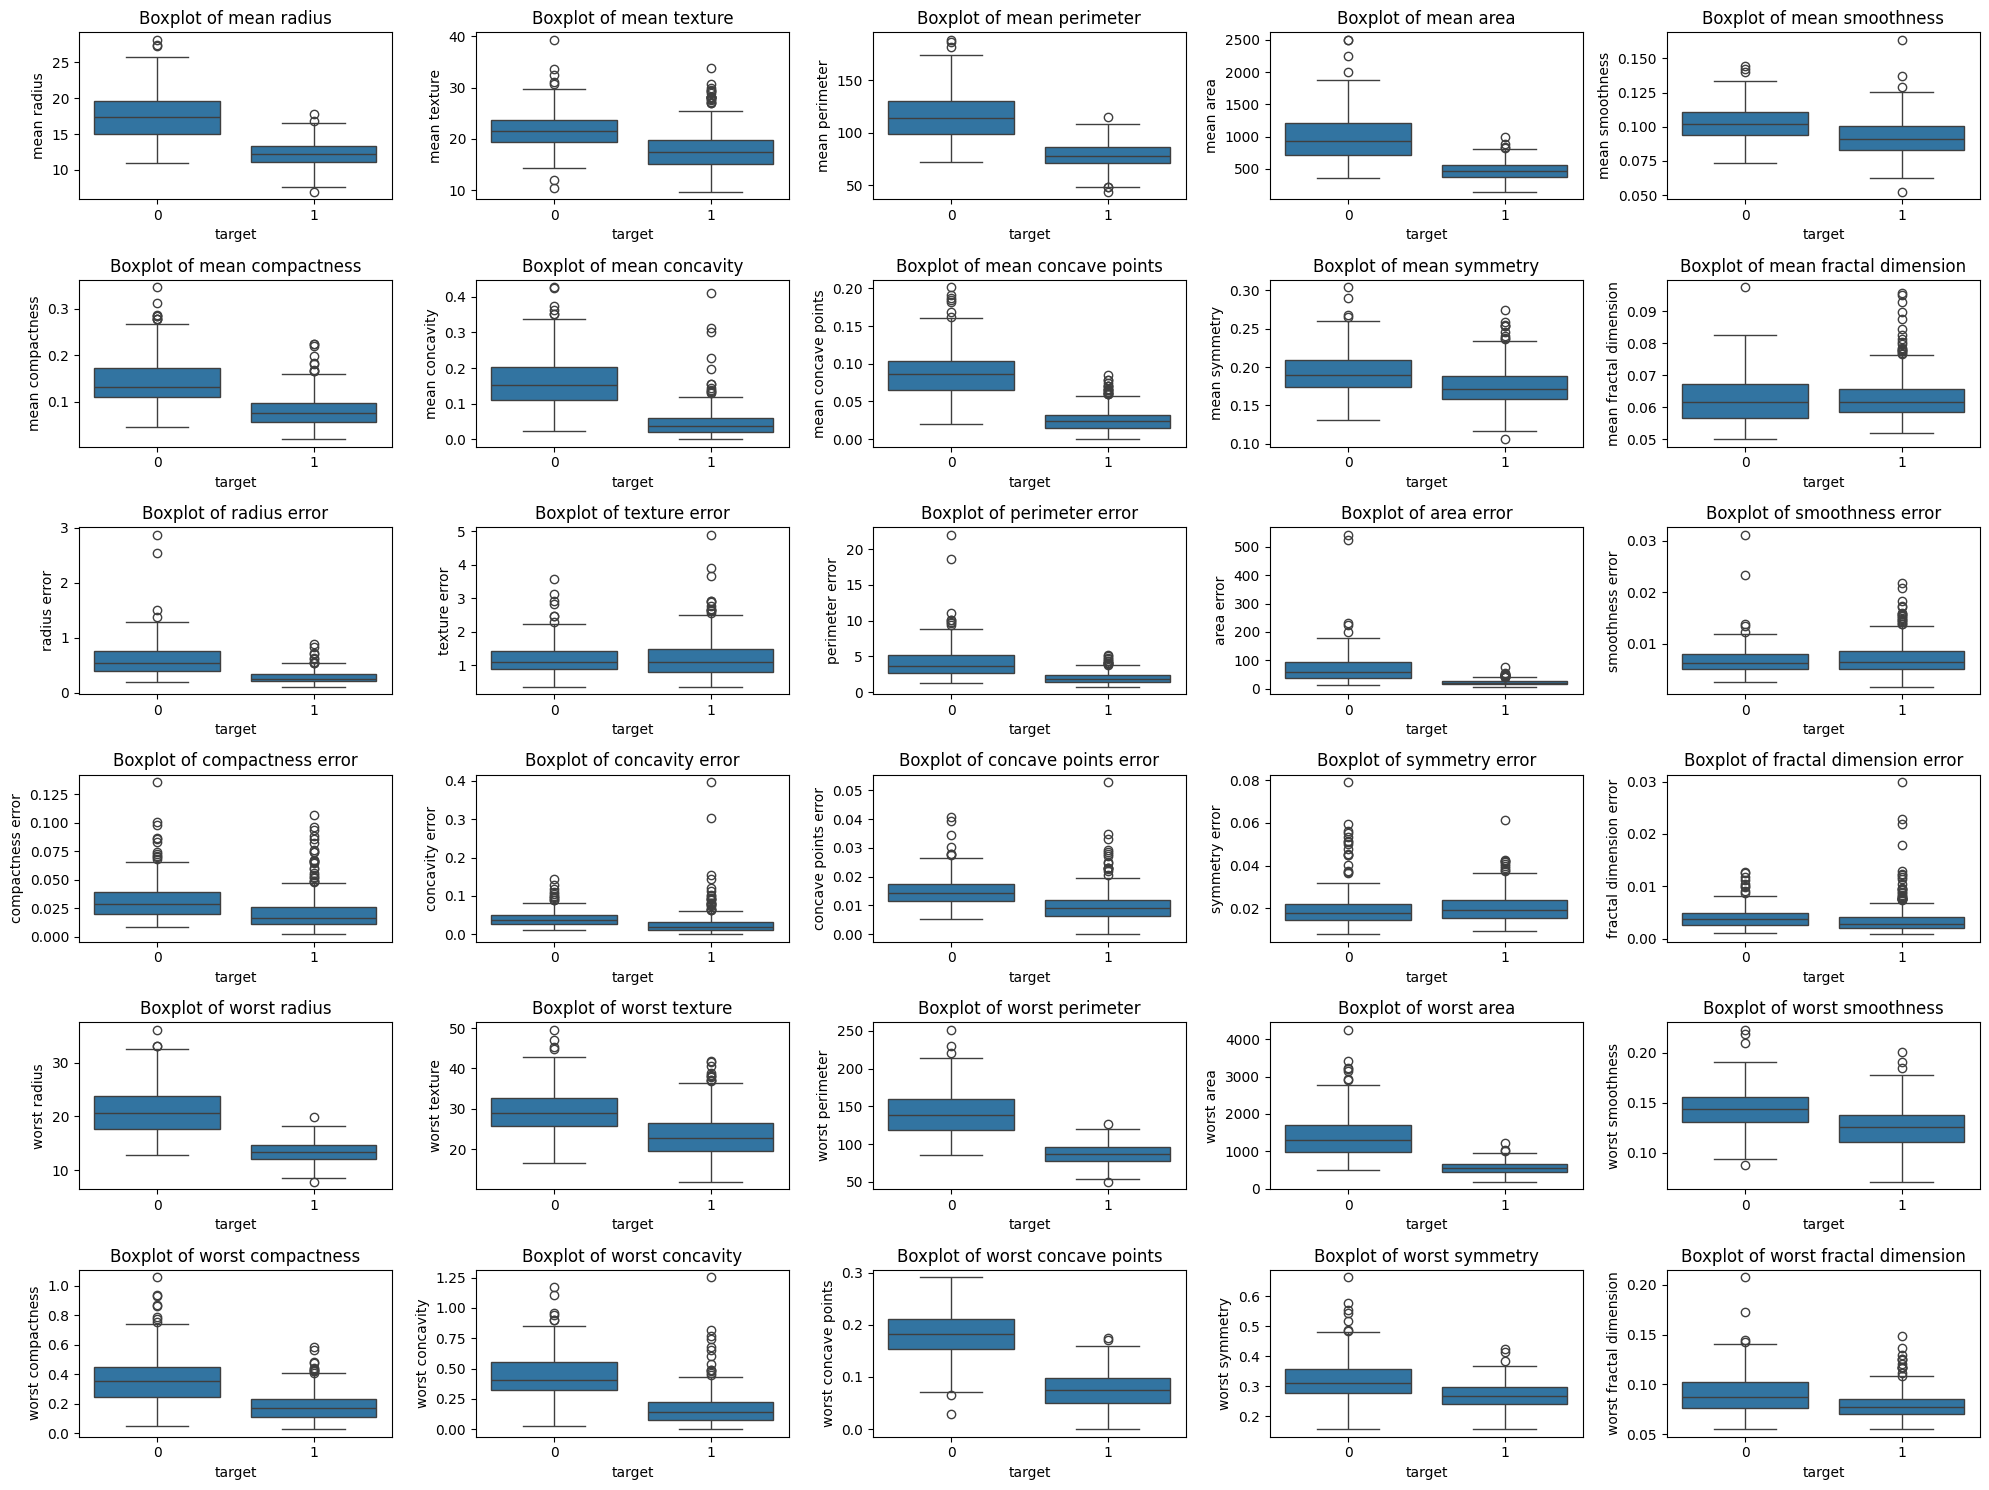

In [49]:
# 根據 target 來分組繪製箱型圖
plt.figure(figsize=(20, 15))  # 增加畫布高度

for i, feature in enumerate(df.columns[:-1]):  # 忽略 'target' 列
    plt.subplot(6, 5, i + 1)  # 每行顯示 5 個子圖
    sns.boxplot(x='target', y=feature, data=df)
    plt.title(f"Boxplot of {feature}")
    plt.tight_layout()

plt.show()

### 2.4 特徵與目標變數之間的關係
用散點圖來檢視特徵與 target 變數（腫瘤類型）之間的關係。這有助於了解某些特徵是否對區分良性和惡性腫瘤有較大的幫助。

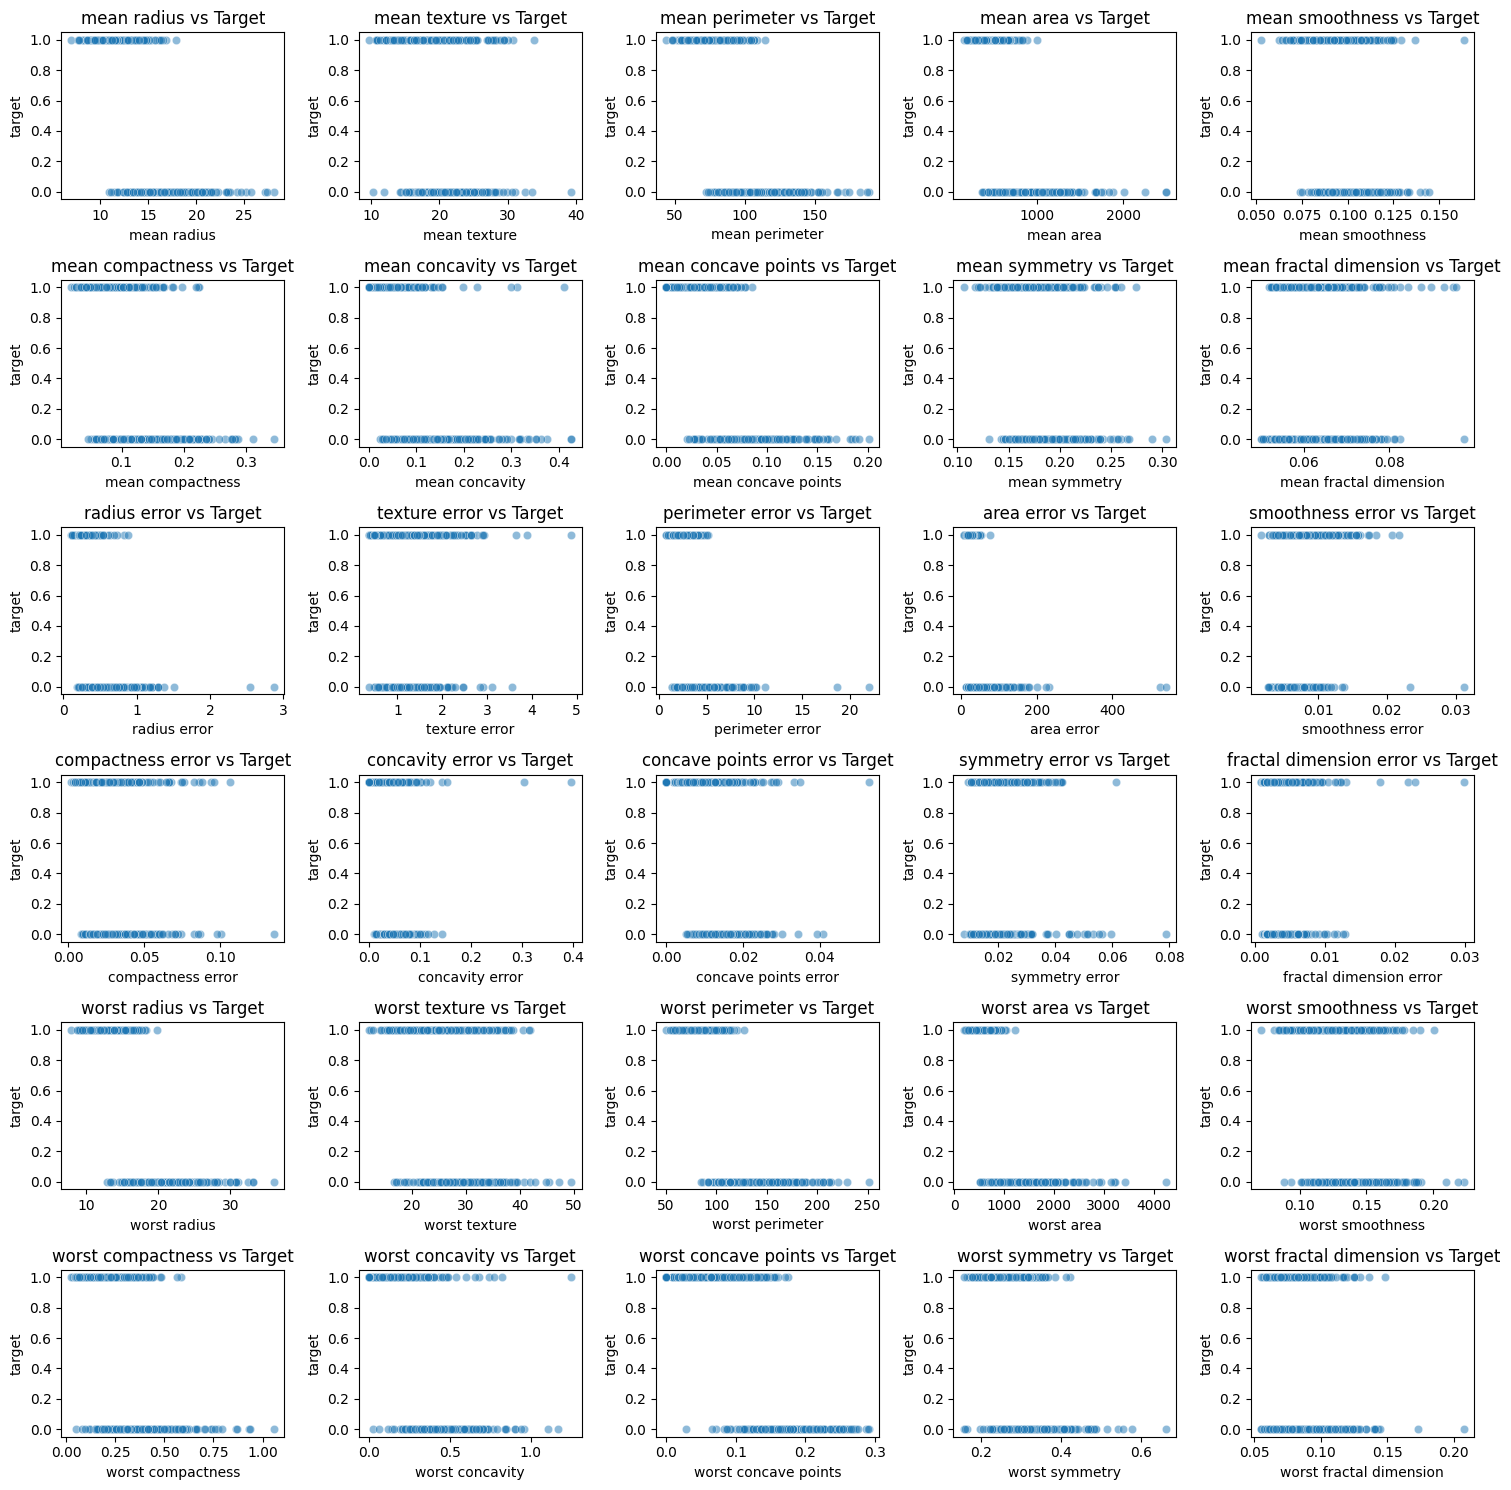

In [48]:
# 繪製每個特徵與 target 的散點圖
plt.figure(figsize=(15, 15))  # 增加畫布高度

for i, feature in enumerate(df.columns[:-1]):  # 忽略 'target' 列
    plt.subplot(6, 5, i + 1)  
    sns.scatterplot(x=df[feature], y=df['target'], alpha=0.5)
    plt.title(f"{feature} vs Target")
    plt.tight_layout()

plt.show()

# 3. 建模

In [ ]:
# 分割資料集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    breast_cancer.data, breast_cancer.target, test_size=0.2, random_state=0)

In [8]:
# 定義基本模型
base_models = [
    RandomForestClassifier(n_estimators=100, random_state=0),
    XGBClassifier(n_estimators=100, random_state=0),
    SVC(probability=True, random_state=0)
]

定義三個基本的機器學習模型，這些模型將用於訓練並生成最終預測結果的特徵（基模型的預測）。    
這些基模型將在訓練過程中相互合作，然後它們的預測結果將作為特徵輸入到 meta-model（元模型）。

In [50]:
# 定義 meta-model
meta_model = LogisticRegression(random_state = 0)

meta-model 會基於基模型的預測結果進行學習，並產生最終的預測結果。

In [9]:
# 定義交叉驗證的 fold 數量
n_folds = 5   # 表示進行 5 折交叉驗證。即資料會被劃分成 5 個子集，每次用 4 個子集來訓練，剩下的 1 個子集用來驗證。

# 初始化 arrays，用來保存基本模型和 meta-model 的訓練和測試預測結果
base_model_train_pred = np.zeros((X_train.shape[0], len(base_models)))
base_model_test_pred = np.zeros((X_test.shape[0], len(base_models)))

In [10]:
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
# StratifiedKFold: 是一種「保留類別比例」的 K 折交叉驗證法。
# 比起一般 KFold，它會確保：每一折（fold）裡，目標變數（例如 churn = 1 / 0）的比例和整體資料集差不多。
# 總結：StratifiedKFold 是讓交叉驗證在分類任務中更穩定、公平的做法，尤其適合處理類別不平衡的資料集。

for i, model in enumerate(base_models):
    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
        X_valid_fold, y_valid_fold = X_train[valid_idx], y_train[valid_idx]

        model.fit(X_train_fold, y_train_fold)
        base_model_train_pred[valid_idx, i] = model.predict_proba(X_valid_fold)[:, 1]
        base_model_test_pred[:, i] += model.predict_proba(X_test)[:, 1] / n_folds

In [51]:
# 使用基本模型的預測結果訓練 meta-model
meta_model.fit(base_model_train_pred, y_train)

# 使用 meta-model 預測測試集
pred = meta_model.predict_proba(base_model_test_pred)[:, 1] # 對應於類別 "1" 的預測機率（通常是指正類，1 類）。這樣可以獲得每個樣本屬於類別 1 的預測機率。

使用基本模型（base models）進行預測後，將其預測結果作為特徵來訓練一個 meta-model，並利用這個 meta-model 來進行最終的預測。
最後，計算 log loss 來評估模型的預測性能。

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss
import numpy as np
import pandas as pd

# Assuming the necessary variables (e.g., base_models, meta_model, etc.) are already defined

# Define lists to store the metrics
base_model_metrics = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc_roc": [],
    "log_loss": [],
    "confusion_matrix": []
}

meta_model_metrics = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc_roc": [],
    "log_loss": [],
    "confusion_matrix": []
}

# Evaluate the base models
for i, model in enumerate(base_models):
    print(f"Evaluating model {i+1}: {model.__class__.__name__}")
    
    # Training set evaluation
    y_train_pred = base_model_train_pred[:, i]
    
    # For classification metrics, convert probabilities to class predictions (0 or 1)
    y_train_pred_class = (y_train_pred >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_train, y_train_pred_class)
    precision = precision_score(y_train, y_train_pred_class)
    recall = recall_score(y_train, y_train_pred_class)
    f1 = f1_score(y_train, y_train_pred_class)
    auc_roc = roc_auc_score(y_train, y_train_pred)
    logloss = log_loss(y_train, y_train_pred)
    conf_matrix = confusion_matrix(y_train, y_train_pred_class)
    
    # Store metrics
    base_model_metrics["model"].append(model.__class__.__name__)
    base_model_metrics["accuracy"].append(accuracy)
    base_model_metrics["precision"].append(precision)
    base_model_metrics["recall"].append(recall)
    base_model_metrics["f1_score"].append(f1)
    base_model_metrics["auc_roc"].append(auc_roc)
    base_model_metrics["log_loss"].append(logloss)
    base_model_metrics["confusion_matrix"].append(conf_matrix)
    
    # Test set evaluation
    y_test_pred = base_model_test_pred[:, i]
    
    # Convert probabilities to class predictions for test set
    y_test_pred_class = (y_test_pred >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_test_pred_class)
    precision = precision_score(y_test, y_test_pred_class)
    recall = recall_score(y_test, y_test_pred_class)
    f1 = f1_score(y_test, y_test_pred_class)
    auc_roc = roc_auc_score(y_test, y_test_pred)
    logloss = log_loss(y_test, y_test_pred)
    conf_matrix = confusion_matrix(y_test, y_test_pred_class)
    
    # Store metrics for test set
    base_model_metrics["model"].append(model.__class__.__name__ + "_test")
    base_model_metrics["accuracy"].append(accuracy)
    base_model_metrics["precision"].append(precision)
    base_model_metrics["recall"].append(recall)
    base_model_metrics["f1_score"].append(f1)
    base_model_metrics["auc_roc"].append(auc_roc)
    base_model_metrics["log_loss"].append(logloss)
    base_model_metrics["confusion_matrix"].append(conf_matrix)

# Now evaluate the meta-model (Logistic Regression)
print(f"Evaluating meta-model: {meta_model.__class__.__name__}")

# Training set evaluation for meta-model
y_train_pred_meta = meta_model.predict_proba(base_model_train_pred)[:, 1]

# Convert probabilities to class predictions for the meta-model
y_train_pred_meta_class = (y_train_pred_meta >= 0.5).astype(int)

accuracy = accuracy_score(y_train, y_train_pred_meta_class)
precision = precision_score(y_train, y_train_pred_meta_class)
recall = recall_score(y_train, y_train_pred_meta_class)
f1 = f1_score(y_train, y_train_pred_meta_class)
auc_roc = roc_auc_score(y_train, y_train_pred_meta)
logloss = log_loss(y_train, y_train_pred_meta)
conf_matrix = confusion_matrix(y_train, y_train_pred_meta_class)

# Store metrics for meta-model
meta_model_metrics["model"].append("meta_model")
meta_model_metrics["accuracy"].append(accuracy)
meta_model_metrics["precision"].append(precision)
meta_model_metrics["recall"].append(recall)
meta_model_metrics["f1_score"].append(f1)
meta_model_metrics["auc_roc"].append(auc_roc)
meta_model_metrics["log_loss"].append(logloss)
meta_model_metrics["confusion_matrix"].append(conf_matrix)

# Test set evaluation for meta-model
y_test_pred_meta = meta_model.predict_proba(base_model_test_pred)[:, 1]

# Convert probabilities to class predictions for meta-model test set
y_test_pred_meta_class = (y_test_pred_meta >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_test_pred_meta_class)
precision = precision_score(y_test, y_test_pred_meta_class)
recall = recall_score(y_test, y_test_pred_meta_class)
f1 = f1_score(y_test, y_test_pred_meta_class)
auc_roc = roc_auc_score(y_test, y_test_pred_meta)
logloss = log_loss(y_test, y_test_pred_meta)
conf_matrix = confusion_matrix(y_test, y_test_pred_meta_class)

# Store metrics for meta-model test set
meta_model_metrics["model"].append("meta_model_test")
meta_model_metrics["accuracy"].append(accuracy)
meta_model_metrics["precision"].append(precision)
meta_model_metrics["recall"].append(recall)
meta_model_metrics["f1_score"].append(f1)
meta_model_metrics["auc_roc"].append(auc_roc)
meta_model_metrics["log_loss"].append(logloss)
meta_model_metrics["confusion_matrix"].append(conf_matrix)

# Convert metrics dictionaries to DataFrames
base_model_metrics_df = pd.DataFrame(base_model_metrics)
meta_model_metrics_df = pd.DataFrame(meta_model_metrics)

# Combine base models and meta-model metrics
all_metrics_df = pd.concat([base_model_metrics_df, meta_model_metrics_df], ignore_index=True)

# Display the final metrics DataFrame
print("\n--- Final Model Evaluation Metrics ---")
all_metrics_df

Evaluating model 1: RandomForestClassifier
Evaluating model 2: XGBClassifier
Evaluating model 3: SVC
Evaluating meta-model: LogisticRegression

--- Final Model Evaluation Metrics ---


,model,accuracy,precision,recall,f1_score,auc_roc,log_loss,confusion_matrix
0,RandomForestClassifier,0.953846,0.955932,0.972414,0.964103,0.987032,0.195252,"[[152, 13], [8, 282]]"
1,RandomForestClassifier_test,0.956140,0.969697,0.955224,0.962406,0.996030,0.102782,"[[45, 2], [3, 64]]"
2,XGBClassifier,0.962637,0.962712,0.979310,0.970940,0.988610,0.118859,"[[154, 11], [6, 284]]"
3,XGBClassifier_test,0.964912,0.970149,0.970149,0.970149,0.997142,0.060450,"[[45, 2], [2, 65]]"
4,SVC,0.912088,0.903226,0.965517,0.933333,0.970617,0.209147,"[[135, 30], [10, 280]]"
5,SVC_test,0.947368,0.942029,0.970149,0.955882,0.984122,0.167599,"[[43, 4], [2, 65]]"
6,meta_model,0.960440,0.959459,0.979310,0.969283,0.989613,0.111918,"[[153, 12], [6, 284]]"
7,meta_model_test,0.973684,0.984848,0.970149,0.977444,0.997460,0.085523,"[[46, 1], [2, 65]]"


* Log loss 越小越好：log loss 衡量的是預測概率與真實標籤之間的差距。理論上，log loss 的範圍是從 0 開始（完全準確的預測）到正無窮大（極差的預測）。因此，數值越小表示模型的預測越準確。

# 新的資料如何使用 stacking

In [65]:
import numpy as np

# 假設 new_data 的 shape 為 (10, 30)，即有 10 筆資料，每筆資料有 30 個特徵
new_data = np.random.rand(10, 30)

# 使用已訓練好的 base models 預測 new_data
base_model_pred = np.zeros((10, len(base_models)))  # 因為有 10 筆資料，所以維度是 (10, len(base_models))

for i, model in enumerate(base_models):
    base_model_pred[:, i] = model.predict_proba(new_data)[:, 1]  # 預測每個模型的正樣本機率

# 使用 meta-model 進行預測
meta_model_pred = meta_model.predict_proba(base_model_pred)[:, 1]  # 這裡的 shape 是 (10,)，代表 10 筆資料的預測結果

meta_model_pred  # 輸出每筆資料的預測結果

array([0.96797191, 0.952826  , 0.87521986, 0.92820133, 0.88282183,
       0.88751251, 0.89641094, 0.88176898, 0.85446761, 0.91511163])

In [66]:
final_predictions = (meta_model_pred > 0.5).astype(int)
print(final_predictions)  # 顯示每筆資料的最終分類結果 (0 或 1)

[1 1 1 1 1 1 1 1 1 1]
